In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 6.7 MB/s eta 0:00:00


In [ ]:

!wget "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
!unzip traffic-signs-data.zip

--2023-12-31 03:15:29--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.226.237.86, 13.226.237.95, 13.226.237.137, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.226.237.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  48.8MB/s    in 2.4s    

2023-12-31 03:15:32 (48.8 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [ ]:
import pickle
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
   train = pickle.load(f)
with open(validation_file, mode='rb') as f:
   valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
   test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(34799,)


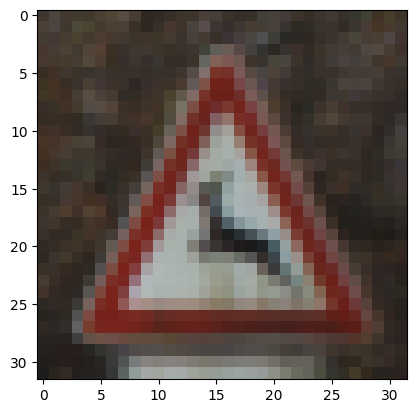

31


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

randomIndex = np.random.randint(0, len(X_train))
randomImage = X_train[randomIndex]

plt.imshow(randomImage)
plt.show()
print(y_train[randomIndex])

(32, 32, 3)


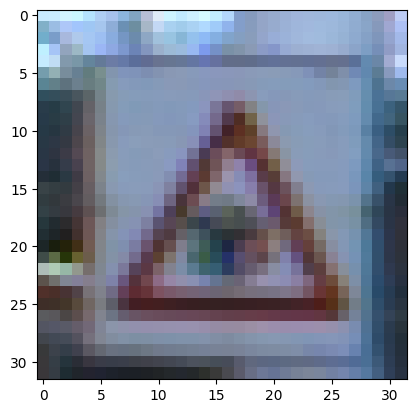

30
(34799, 32, 32, 1)
(32, 32, 1)


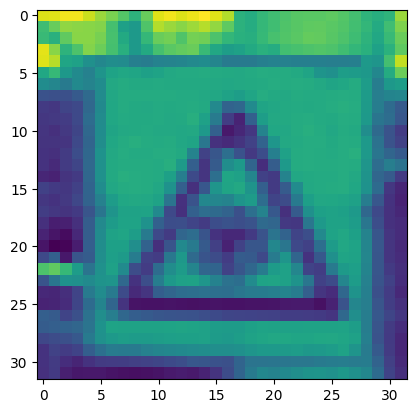

(32, 32, 1)


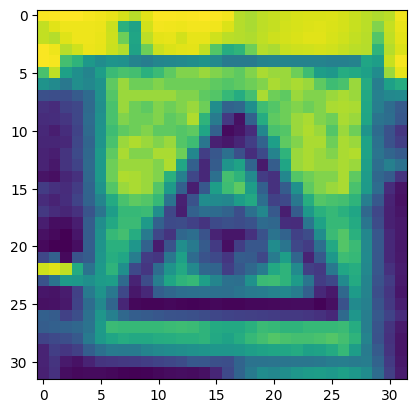

In [ ]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

randomImage = X_train[randomIndex]
print(randomImage.shape)
plt.imshow(randomImage)
plt.show()
print(y_train[randomIndex])


preprocessed_train_images = []
preprocessed_test_images = []

for i in range(len(X_train)):
  img = cv2.cvtColor(X_train[i],cv2.COLOR_BGR2GRAY)
  img = img.reshape(32,32,1)
  preprocessed_train_images.append(img)

for i in range(len(X_test)):
  img = cv2.cvtColor(X_test[i],cv2.COLOR_BGR2GRAY)
  img = img.reshape(32,32,1)
  preprocessed_test_images.append(img)



preprocessed_train_images_numpy = np.array(preprocessed_train_images)
preprocessed_test_images_numpy = np.array(preprocessed_test_images)
print(preprocessed_train_images_numpy.shape)


randomImage = preprocessed_train_images_numpy[randomIndex]
print(randomImage.shape)
randomImage = randomImage.squeeze()
plt.imshow(randomImage)
plt.show()

#HistogramEqualization-Train
preprocessed_train_images_numpy = preprocessed_train_images_numpy.astype(np.uint8)
for i in range(len(preprocessed_train_images_numpy)):
  img = cv2.equalizeHist(preprocessed_train_images_numpy[i])
  img = img.reshape(32,32,1)
  preprocessed_train_images_numpy[i] = img

#HistogramEqualization-Test
preprocessed_test_images_numpy = preprocessed_test_images_numpy.astype(np.uint8)
for i in range(len(preprocessed_test_images_numpy)):
  img = cv2.equalizeHist(preprocessed_test_images_numpy[i])
  img = img.reshape(32,32,1)
  preprocessed_test_images_numpy[i] = img

randomImage = preprocessed_train_images_numpy[randomIndex]
print(randomImage.shape)
randomImage = randomImage.squeeze()
plt.imshow(randomImage)
plt.show()

#Normalization
preprocessed_train_images_numpy = preprocessed_train_images_numpy/255.0 -0.5
preprocessed_test_images_numpy = preprocessed_test_images_numpy/255.0 -0.5

In [ ]:
from keras.utils import to_categorical
encoded = to_categorical(y_train)
test_encoded  = to_categorical(y_test)
print(encoded.shape)


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


n_classes = 43


x = tf.placeholder(tf.float32, shape=[None,32,32,1])
y = tf.placeholder(tf.float32, shape=[None,n_classes])


mu = 0

sigma = 0.1

# Convolution 1
weights_l1 = tf.Variable(tf.truncated_normal([5,5,1,6], mean = mu, stddev=sigma))
biases_l1 = tf.Variable(tf.truncated_normal([6]))

outlayer = tf.nn.conv2d(x, weights_l1, [1,1,1,1], padding="VALID")
outlayer +=biases_l1
outlayer = tf.nn.relu(outlayer)

# Maxpooling 1
outlayer = tf.nn.max_pool(outlayer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

# Convolution 2
weights_l2 = tf.Variable(tf.truncated_normal([5,5,6,16], mean = mu, stddev=sigma))
biases_l2 = tf.Variable(tf.truncated_normal([16]))

outlayer = tf.nn.conv2d(outlayer, weights_l2, [1,1,1,1], padding="VALID")
outlayer += biases_l2
outlayer = tf.nn.relu(outlayer)

# Maxpooling 2
outlayer = tf.nn.max_pool(outlayer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
print(outlayer)

# Flattening
flattened = tf.reshape(outlayer,[-1,5*5*16])
print(flattened)

#FC1
wd1 = tf.Variable(tf.truncated_normal([5*5*16, 120], mean = mu, stddev = sigma))
bd1 = tf.Variable(tf.truncated_normal([120]))

outlayer = tf.matmul(flattened,wd1) + bd1
outlayer = tf.nn.relu(outlayer)


#Dropout
outlayer = tf.nn.dropout(outlayer,0.5)

#FC2
wd2 = tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma))
bd2 = tf.Variable(tf.truncated_normal([84]))

outlayer = tf.matmul(outlayer,wd2) + bd2
outlayer = tf.nn.relu(outlayer)

#LastLayer
wd3 = tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma)) # n_classes = 43
bd3 = tf.Variable(tf.truncated_normal([1,n_classes]))

logits = tf.matmul(outlayer,wd3) + bd3

cost = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
cost = tf.reduce_mean(cost)

optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

init = tf.global_variables_initializer()



# Checking accuracy
y_probabilities_predictions = tf.nn.softmax(logits)
y_class_predictions = tf.argmax(y_probabilities_predictions, axis=1)
y_true_labels = tf.argmax(y,1)

correct_predictions = tf.equal(y_class_predictions, y_true_labels)
total_correct = tf.reduce_sum(tf.cast(correct_predictions, tf.float32))




Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


(34799, 43)
Tensor("MaxPool_1:0", shape=(?, 5, 5, 16), dtype=float32)
Tensor("Reshape:0", shape=(?, 400), dtype=float32)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [ ]:
epochs = 50
batch_size = 130
saver = tf.train.Saver()
Train_accuracy_figure = []
Test_accuracy_figure = []
epoch_loss_array=[]
with tf.Session() as sess:
  init.run()
  for epoch in range(epochs):
    epoch_loss = 0
    #training by batches
    for offset in range(0, len(X_train), batch_size):
      end = offset + batch_size
      batch_x = preprocessed_train_images_numpy[offset:end]
      batch_y = encoded[offset:end]
      sess.run(optimizer, feed_dict={x:batch_x, y:batch_y})
      c = sess.run(cost, feed_dict = {x:batch_x, y:batch_y})
      epoch_loss += c
      epoch_loss_array.append(epoch_loss)
    #Accuracy of test data
    total_accuracy_test = 0
    for offset in range(0,len(X_test),batch_size):
      end = offset + batch_size
      batch_x = preprocessed_test_images_numpy[offset:end]
      batch_y = test_encoded[offset:end]
      total_accuracy_in_batch = sess.run(total_correct,feed_dict={x:batch_x , y:batch_y})
      total_accuracy_test += total_accuracy_in_batch

     #Accuracy of train data
    total_accuracy_train = 0
    for offset in range(0,len(preprocessed_train_images_numpy),batch_size):
      end = offset + batch_size
      batch_x = preprocessed_train_images_numpy[offset:end]
      batch_y = encoded[offset:end]
      total_accuracy_in_batch = sess.run(total_correct,feed_dict={x:batch_x , y:batch_y})
      total_accuracy_train += total_accuracy_in_batch

    print("Epoch ",epoch," Epoch_Loss ",epoch_loss)
    Train_Accuracy = total_accuracy_train / len(preprocessed_train_images_numpy)
    Test_Accuracy = total_accuracy_test / len(preprocessed_test_images_numpy)
    Train_accuracy_figure.append(Train_Accuracy)
    Test_accuracy_figure.append(Test_Accuracy)

    print("Train Accuracy ",Train_Accuracy)
    print("Test Accuracy ",Test_Accuracy)
  saver.save(sess,'./model.ckpt')

Epoch  0  Epoch_Loss  773.007205247879
Train Accuracy  0.4894393517055088
Test Accuracy  0.45605700712589076
Epoch  1  Epoch_Loss  328.0696687698364
Train Accuracy  0.6961119572401506
Test Accuracy  0.6275534441805226
Epoch  2  Epoch_Loss  217.7371551990509
Train Accuracy  0.780395988390471
Test Accuracy  0.7083927157561362
Epoch  3  Epoch_Loss  170.07158780097961
Train Accuracy  0.8147360556337826
Test Accuracy  0.7428345209817894
Epoch  4  Epoch_Loss  143.40020263195038
Train Accuracy  0.8474668812322194
Test Accuracy  0.7704671417260491
Epoch  5  Epoch_Loss  123.11368654668331
Train Accuracy  0.8652547486996752
Test Accuracy  0.7883610451306413
Epoch  6  Epoch_Loss  110.63839310407639
Train Accuracy  0.8771516422885716
Test Accuracy  0.7957244655581948
Epoch  7  Epoch_Loss  98.87444412708282
Train Accuracy  0.8873243484008161
Test Accuracy  0.8004750593824228
Epoch  8  Epoch_Loss  89.38518454134464
Train Accuracy  0.897985574298112
Test Accuracy  0.8062549485352336
Epoch  9  Epoch_L

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    y_train_pred = sess.run(y_class_predictions, feed_dict={x: preprocessed_train_images_numpy, y: encoded})

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    y_pred = sess.run(y_class_predictions, feed_dict={x: preprocessed_test_images_numpy, y: test_encoded})

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_train = precision_score(y_train, y_train_pred, average = 'weighted')
recall_train = recall_score(y_train, y_train_pred, average = 'weighted')
f1_train = f1_score(y_train, y_train_pred, average = 'weighted')
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
print("Train")
print("Accuracy :",total_accuracy_train / len(preprocessed_train_images_numpy))
print("F1 Score :", f1_train)
print("Recall :", recall_train)
print("Precision :", precision_train)
print("Test")
print("Accuracy :",total_accuracy_test / len(preprocessed_test_images_numpy))
print("F1 Score :", f1)
print("Recall :", recall)
print("Precision :", precision)

Train
Accuracy : 0.972269318083853
F1 Score : 0.9705220808414272
Recall : 0.9705738670651456
Precision : 0.9708717705970715
Test
Accuracy : 0.8881235154394299
F1 Score : 0.8853212989555374
Recall : 0.886381631037213
Precision : 0.8875621260728268


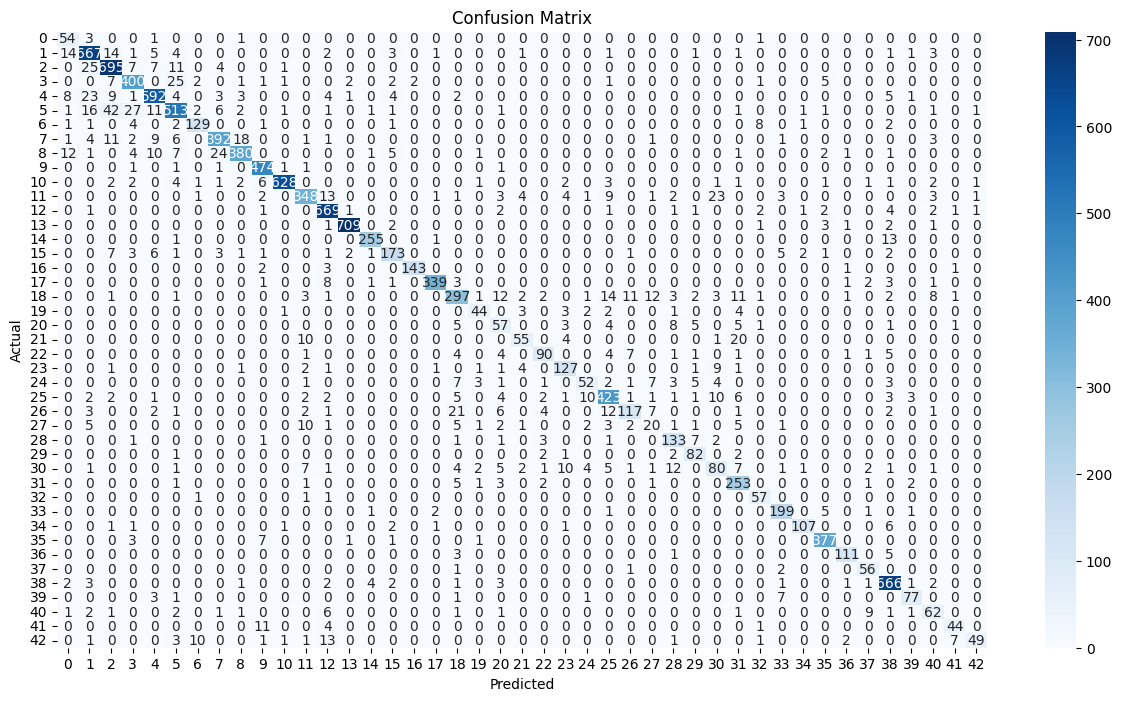

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 8))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

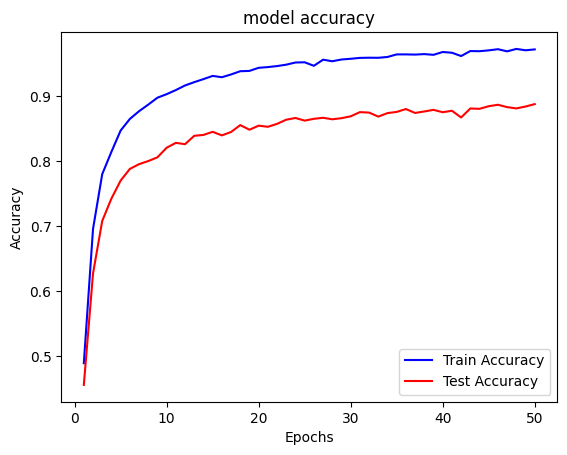

In [ ]:
epochs = range(1, len(Train_accuracy_figure) + 1)
plt.plot(epochs, Train_accuracy_figure, 'b', label='Train Accuracy')
plt.plot(epochs, Test_accuracy_figure, 'r', label='Test Accuracy')
plt.title('model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

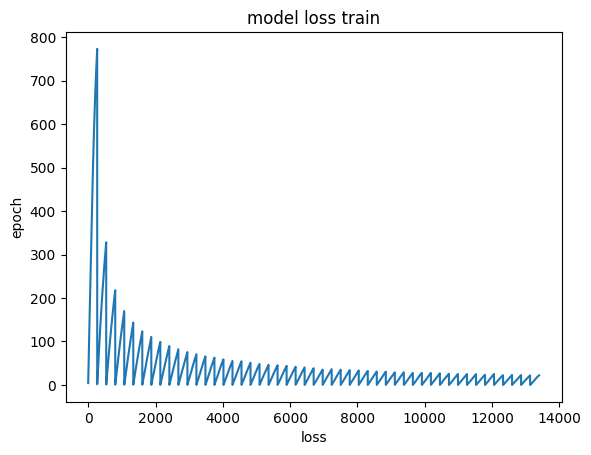

In [ ]:
plt.plot(epoch_loss_array)
plt.title("model loss train")
plt.xlabel('loss')
plt.ylabel('epoch')
plt.show()

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
img = cv2.imread("images.png")

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img = cv2.resize(img,(32,32))
print(img.shape)

img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img = img.reshape(32,32,1)
img = img.astype(np.uint8)
img = cv2.equalizeHist(img)
img = img.reshape(32,32,1)
img = img/225-0.5

with tf.Session() as sess:
  saver.restore(sess,"./model.ckpt")
  print("labels",sess.run(y_class_predictions,feed_dict={x:[img]}))